In [834]:
from dataclasses import dataclass, field
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re


# Новый тип данных "Operation_History"
@dataclass
class Operation_History():
    type_operation: str = None
    summa_operation: float = 0
    data_time_operation: datetime = 0
    current_balance: float = 0
    status: str = None
    

**Класс Account**

In [835]:
class Account:
    __account_counter: int = 100001
    __balance: float = 0
        
    def __init__(self, account_holder, balance = 0):
        # Инициализируем историю
        self.operations_history: list[Operation_History] = []
        
        # Проверяем корректность имени владельца счета (отдельно на русском, отдельно на английском), если все хорошо, то присваиваем имя
        nameRu = re.findall(r"^[А-ЯЁ][а-яё]+ [А-ЯЁ][а-яё]+$", account_holder)
        nameEn = re.findall(r"^[A-Z][a-z]+ [A-Z][a-z]+$", account_holder)
        if nameRu or nameEn:
            self.holder = account_holder
        else:
            raise ValueError("Не верный формат Фамилия Имя!")
        
        # Проверка на отрицательный баланс, если все хорошо, то присваиваем новый баланс
        if balance < 0:
            raise ValueError("Начальный баланс счёта, не может быть отрицательным!") 
        self.__balance = balance

        # Генерация номера счета и изменение количества созданных счетов
        self.account_number = 'ACC-{}'.format(self.__account_counter)
        Account.__account_counter +=1
        
        # Инициализируем датафрейм
        self.history_df = pd.DataFrame()

    def deposit (self, amount):

        # Проверка на положительное пополнение, если все хорошо, то увеличиваем баланс
        if amount < 0:
            raise ValueError("Сумма пополнения счёта не может быть отрицательной!") 
        self.__balance += amount

        # Добавление нового объекта Operation_History в список истории операций
        self.operations_history.append(Operation_History('deposit', amount, datetime.now(), self.__balance, 'success'))

    def withdraw (self, amount):

        # Проверка на положительное снятие, если все хорошо, то проверяем возможность снятия и добавляем новую строчку в список истории операций
        if amount < 0:
            raise ValueError("Сумма снятия со счёта не может быть отрицательной!")
        if amount <= self.__balance:
            self.__balance -= amount
            self.operations_history.append(Operation_History('withdraw', amount, datetime.now(), self.__balance, 'success'))
        else:
            print ('Недостаточно средств на счёте для снятия!')
            self.operations_history.append(Operation_History('withdraw', amount, datetime.now(), self.__balance, 'fail'))
    
    def plot_history(self):
        # С помощью генераторного выражения преобразуем историю операций и на основе него создаем новый датафрейм
        self.history_df = pd.DataFrame(((operation.type_operation, operation.summa_operation, operation.data_time_operation, operation.current_balance, operation.status)
        for operation in self.operations_history), columns=['Type_Operation','Summa','Data', 'Current_Balance', 'Status'])

    def show_chart (self):
        # Проверяем датафрейм на пустоту, если данные есть, то рисуем график только по успешным операциям
        if self.history_df.empty:
           print ('Датафрейм пустой!')
        else:
           history_df_new = self.history_df[self.history_df['Status'] == 'success']
           sns.lineplot(history_df_new, x='Data', y='Current_Balance')
           plt.title('Изменение баланса со временем', fontsize=16, weight='bold')
           plt.xlabel('Дата и время', fontsize=12)
           plt.ylabel('Баланс', fontsize=12)
           plt.show()    

    def history_analysis (self, count = None):
        self.plot_history()
        sorted_history_df = self.history_df
        # Добавляем в датафрейм новый столбик с датой без времени и сортируем датафрейм по дате и сумме операции
        sorted_history_df['DataNotTime'] = pd.to_datetime(sorted_history_df['Data']).dt.date
        sorted_history_df = self.history_df.sort_values(by=['DataNotTime', 'Summa'], ascending=[False, False])
        print(sorted_history_df.head(count))
        

    def get_history(self):
        # Выводим историю операций...
        for operation in self.operations_history:
           print(operation.type_operation, operation.summa_operation, operation.data_time_operation, operation.current_balance, operation.status)
            #datetime.strptime('11.10.13', '%Y-%m-%d %H:%M:%S.%f')
            #return self.operations_history

    # Геттер и сеттер для текущего баланса
    @property
    def get_balance(self):
        return self.__balance
    
    @get_balance.setter
    def get_balance(self, value) -> None:
        self.__balance = value

**Класс CheckingAccount**

In [836]:
class CheckingAccount(Account):
    def __init__(self, account_holder, balance=0):
        super().__init__(account_holder, balance)
        self.account_type = 'checking'

    def __clean_history(self, df):
        # Фильтруем датафрейм под нужды (выбираем нужный аккаунт и его тип -> выбираем нужные операции и отсееваем отрицательные суммы -> проверяем даты (преобразуем в datatime))
        df = df.loc[(df['account_number'] == self.account_number) & (df['account_type'] == self.account_type)]
        df = df.loc[((df['operation'] == 'deposit') | (df['operation'] == 'withdraw')) & (df['amount'] >= 0)] 

        df['DataClean'] =df['date'].apply(self.__ValidData)

        df = df[df['DataClean'].notna()]
        return df 
      
    def uploading_to_history (self):
        # Читаем и фильтруем датафрейм
        self.__dirtyDF = pd.read_csv('transactions_dirty.csv')
        self.__dirtyDF = self.__clean_history(self.__dirtyDF)

        # Загружаем данные в историю операций и обновляем баланс
        for stroka in self.__dirtyDF.itertuples():
            if stroka.operation == 'deposit':
                self.get_balance += stroka.amount
                self.operations_history.append(Operation_History('deposit', stroka.amount, stroka.DataClean, self.get_balance, 'success'))
            elif stroka.operation == 'withdraw' and stroka.status == 'success':
                self.get_balance -= stroka.amount
                self.operations_history.append(Operation_History('withdraw', stroka.amount, stroka.DataClean, self.get_balance, 'success'))
            elif stroka.operation == 'withdraw' and stroka.status == 'fail':
                self.operations_history.append(Operation_History('withdraw', stroka.amount, stroka.DataClean, self.get_balance, 'fail'))

    def __ValidData (self, data):
        # Попытки преобразования в datatime, если даты неверны или не соответсвуют шаблонам то None
        try:
            data = datetime.strptime(data, '%Y-%m-%d %H:%M:%S')
        except:
            try: 
                data = datetime.strptime(data, '%d/%m/%Y %H:%M')
            except:
                return None
        return data


**Класс SavingsAccount**

In [837]:
class SavingsAccount(Account):
    def __init__(self, account_holder, balance=0):
        super().__init__(account_holder, balance)
        self.account_type = 'savings'
        self.percent = 0

    # Расчет процента на остаток (Прим.: реализован расчет (процент не начисляю) на текущий баланс за 1 день)
    def apply_interest(self, rate):
        days = 1
        self.percent = self.get_balance * (rate/100) * (days/365)
        # Проверка на положительное пополнение, если все хорошо, то увеличиваем баланс
        if self.percent < 0:
            raise ValueError("Годовой процент не может быть отрицательным!") 
        self.get_balance += round(self.percent, 2)

        # Добавление нового объекта Operation_History в список истории операций
        self.operations_history.append(Operation_History('interest', round(self.percent, 2), datetime.now(), self.get_balance, 'success'))
        
    def withdraw (self, amount):
       # Проверка на положительное снятие, если все хорошо, то проверяем возможность снятия и добавляем новую строчку в список истории операций
        if amount < 0:
            raise ValueError("Сумма снятия со счёта не может быть отрицательной!")
        
        if amount <= (self.get_balance * 0.5):
            self.get_balance -= amount
            self.operations_history.append(Operation_History('withdraw', amount, datetime.now(), self.get_balance, 'success'))
        elif amount >= (self.get_balance * 0.5) and amount <= self.get_balance:
            print ('Нельзя снять больше 50%!')
            self.operations_history.append(Operation_History('withdraw', amount, datetime.now(), self.get_balance, 'fail'))
        else:
            print ('Недостаточно средств на счёте для снятия!')
            self.operations_history.append(Operation_History('withdraw', amount, datetime.now(), self.get_balance, 'fail')) 

    
    def __clean_history(self, df):
        # Фильтруем датафрейм под нужды (выбираем нужный аккаунт и его тип -> выбираем нужные операции и отсееваем отрицательные суммы -> проверяем даты (преобразуем в datatime))
        df = df.loc[(df['account_number'] == self.account_number) & (df['account_type'] == self.account_type)]
        df = df.loc[((df['operation'] == 'deposit') | (df['operation'] == 'withdraw') | (df['operation'] == 'interest')) & (df['amount'] >= 0)] 

        df['DataClean'] =df['date'].apply(self.__ValidData)

        df = df[df['DataClean'].notna()]
        return df 

     
    def uploading_to_history (self):
        # Читаем и фильтруем датафрейм
        self.__dirtyDF = pd.read_csv('transactions_dirty.csv')
        self.__dirtyDF = self.__clean_history(self.__dirtyDF)

        # Загружаем данные в историю операций и обновляем баланс
        for stroka in self.__dirtyDF.itertuples():
            if stroka.operation == 'deposit':
                self.get_balance += stroka.amount
                self.operations_history.append(Operation_History('deposit', stroka.amount, stroka.DataClean, self.get_balance, 'success'))
            elif stroka.operation == 'interest':
                self.get_balance += stroka.amount
                self.operations_history.append(Operation_History('interest', stroka.amount, stroka.DataClean, self.get_balance, 'success'))
            elif stroka.operation == 'withdraw' and stroka.status == 'success':
                self.get_balance -= stroka.amount
                self.operations_history.append(Operation_History('withdraw', stroka.amount, stroka.DataClean, self.get_balance, 'success'))
            elif stroka.operation == 'withdraw' and stroka.status == 'fail':
                self.operations_history.append(Operation_History('withdraw', stroka.amount, stroka.DataClean, self.get_balance, 'fail'))
    
    def __ValidData (self, data):
        # Попытки преобразования в datatime, если даты неверны или не соответсвуют шаблонам то None
        try:
            data = datetime.strptime(data, '%Y-%m-%d %H:%M:%S')
        except:
            try: 
                data = datetime.strptime(data, '%d/%m/%Y %H:%M')
            except:
                return None
        return data
    

**Немного тестов**

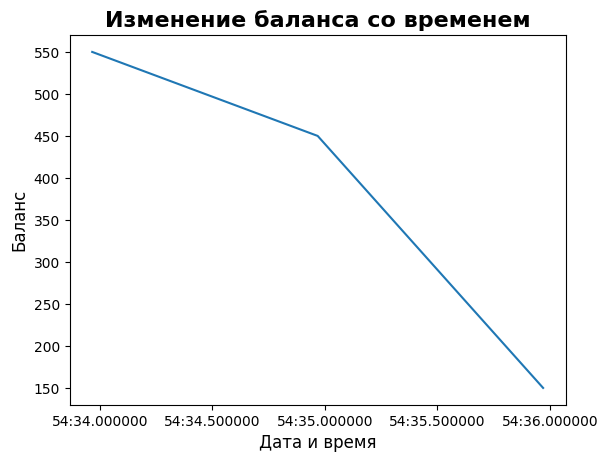

deposit 400 2025-11-08 05:54:33.966447 550 success
withdraw 100 2025-11-08 05:54:34.967935 450 success
withdraw 300 2025-11-08 05:54:35.969137 150 success

-----------------------
  Type_Operation  Summa                       Data  Current_Balance   Status  \
0        deposit    400 2025-11-08 05:54:33.966447              550  success   
2       withdraw    300 2025-11-08 05:54:35.969137              150  success   
1       withdraw    100 2025-11-08 05:54:34.967935              450  success   

  DataNotTime  
0  2025-11-08  
2  2025-11-08  
1  2025-11-08  

-----------------------
Fred Yisli имеет аккаунт номер ACC-100001. Текущий баланс равен 150


In [838]:
Fred = CheckingAccount('Fred Yisli', 150)

Fred.deposit(400)
time.sleep(1)
Fred.withdraw(100)
time.sleep(1)
Fred.withdraw(300)

Fred.plot_history()
Fred.show_chart()

Fred.get_history()
print("\n-----------------------")
Fred.history_analysis()
print("\n-----------------------")
print("{} имеет аккаунт номер {}. Текущий баланс равен {}".format(Fred.holder, Fred.account_number, Fred.get_balance))


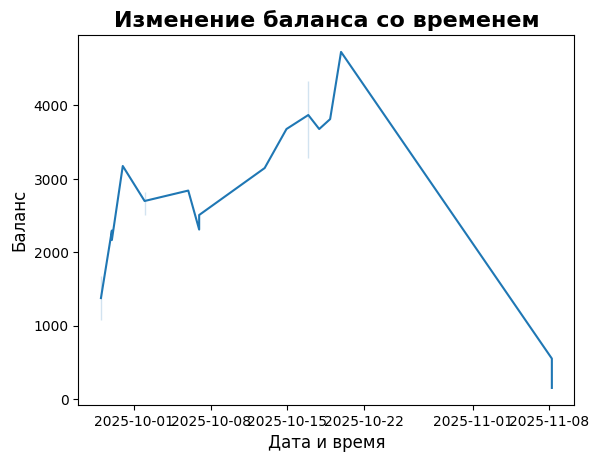

deposit 400 2025-11-08 05:54:33.966447 550 success
withdraw 100 2025-11-08 05:54:34.967935 450 success
withdraw 300 2025-11-08 05:54:35.969137 150 success
deposit 921.0 2025-09-27 22:17:26 1071.0 success
deposit 607.0 2025-09-27 22:17:26 1678.0 success
deposit 488.0 2025-09-28 22:17:26 2166.0 success
deposit 129.0 2025-09-28 22:17:00 2295.0 success
deposit 880.0 2025-09-29 22:17:26 3175.0 success
withdraw 352.0 2025-10-01 22:17:26 2823.0 success
withdraw 65.0 2025-10-01 22:17:26 2758.0 success
withdraw 245.0 2025-10-01 22:17:26 2513.0 success
deposit 327.0 2025-10-05 22:17:26 2840.0 success
withdraw 333.0 2025-10-06 22:17:26 2507.0 success
withdraw 198.0 2025-10-06 22:17:00 2309.0 success
deposit 838.0 2025-10-12 22:17:26 3147.0 success
deposit 532.0 2025-10-14 22:17:26 3679.0 success
withdraw 393.0 2025-10-16 22:17:26 3286.0 success
deposit 701.0 2025-10-16 22:17:26 3987.0 success
withdraw 308.0 2025-10-17 22:17:26 3679.0 success
deposit 135.0 2025-10-18 22:17:26 3814.0 success
deposi

In [839]:
Fred.uploading_to_history()

Fred.plot_history()
Fred.show_chart()

Fred.get_history()



Петр Зелински имеет аккаунт номер ACC-100002. Текущий баланс равен 0
Нельзя снять больше 50%!


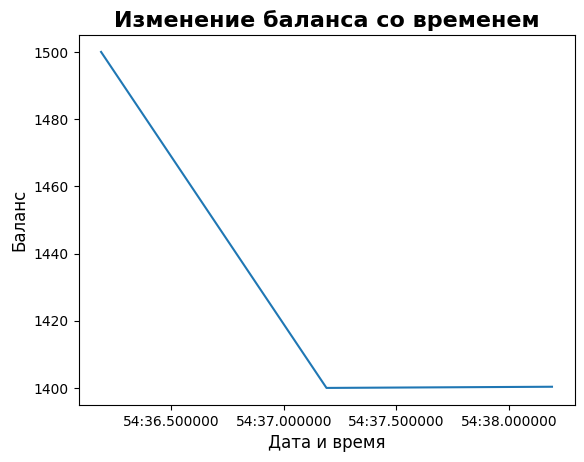

deposit 1500 2025-11-08 05:54:36.188127 1500 success
withdraw 100 2025-11-08 05:54:37.189095 1400 success
withdraw 1000 2025-11-08 05:54:38.190448 1400 fail
interest 0.35 2025-11-08 05:54:38.190448 1400.35 success


In [840]:
Petr = SavingsAccount('Петр Зелински')

print("{} имеет аккаунт номер {}. Текущий баланс равен {}".format(Petr.holder, Petr.account_number, Petr.get_balance))

Petr.deposit(1500)
time.sleep(1)
Petr.withdraw(100)
time.sleep(1)
Petr.withdraw(1000)
Petr.apply_interest(9)

Petr.plot_history()
Petr.show_chart()

Petr.get_history()

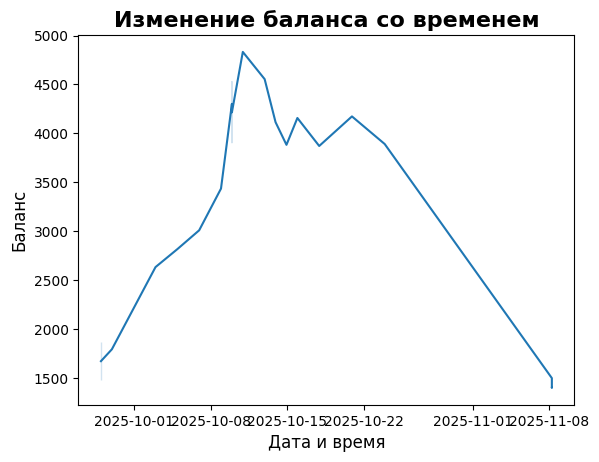

deposit 1500 2025-11-08 05:54:36.188127 1500 success
withdraw 100 2025-11-08 05:54:37.189095 1400 success
withdraw 1000 2025-11-08 05:54:38.190448 1400 fail
interest 0.35 2025-11-08 05:54:38.190448 1400.35 success
deposit 469.0 2025-09-27 22:17:26 1869.35 success
withdraw 392.0 2025-09-27 22:17:26 1477.35 success
deposit 317.0 2025-09-28 22:17:26 1794.35 success
deposit 840.0 2025-10-02 22:17:26 2634.35 success
interest 183.28 2025-10-04 22:17:00 2817.63 success
interest 192.44 2025-10-06 22:17:26 3010.07 success
deposit 426.0 2025-10-08 22:17:26 3436.07 success
deposit 638.0 2025-10-09 22:17:00 4074.07 success
withdraw 170.0 2025-10-09 22:17:26 3904.07 success
deposit 622.0 2025-10-09 22:17:26 4526.07 success
interest 306.26 2025-10-10 22:17:26 4832.33 success
withdraw 278.0 2025-10-12 22:17:26 4554.33 success
withdraw 440.0 2025-10-13 22:17:26 4114.33 success
withdraw 231.0 2025-10-14 22:17:26 3883.33 success
interest 274.13 2025-10-15 22:17:26 4157.46 success
withdraw 286.0 2025-10-

In [841]:
Petr.uploading_to_history()

Petr.plot_history()
Petr.show_chart()

Petr.get_history()